# 코드 설명

0.EDA랑 1.데이터 불러오기는 안돌려도 됩니다! 
바로 밑에 3개 cell이랑 2.데이터 scaling/encoding부터 쭉 돌리면 됩니다.

In [1]:
import os

import numpy as np
import random
import pandas as pd
import ast
from tqdm import tqdm
import pickle
import io
from nltk.tokenize import RegexpTokenizer

import matplotlib.pyplot as plt
%matplotlib inline

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.4f}'.format  # pd.reset_option('display.float_format')

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

In [143]:
recomd = pd.read_csv('inter.csv')

In [144]:
recomd.rename(columns={"app_id": "item_id"}, inplace=True)

# 0. EDA

In [45]:
recomd2 = pd.read_csv('recommendations.csv')

In [50]:
recomd2.rename(columns={"app_id": "item_id"}, inplace=True)

In [46]:
recomd.shape, recomd2.shape

((14529074, 9), (41154794, 8))

In [48]:
recomd["user_id"].nunique(), recomd2["user_id"].nunique()

(680812, 13781059)

In [51]:
recomd["item_id"].nunique(), recomd2["item_id"].nunique()

(37141, 37610)

In [55]:
recomd['interaction'].value_counts()

interaction
1    12144253
0     2384821
Name: count, dtype: int64

In [58]:
recomd2['interaction'].value_counts()

interaction
1    35304398
0     5850396
Name: count, dtype: int64

In [ ]:
df_item = pd.read_csv('item.csv')
recomd2 = recomd2.merge(df_item, on='item_id', how='left')

In [54]:
recomd2.isna().sum()

item_id                            0
helpful                            0
funny                              0
date                               0
is_recommended                     0
hours                              0
user_id                            0
review_id                          0
title                         151993
date_release                  151993
win                           151993
mac                           151993
linux                         151993
positive_ratio                151993
price_final                   151993
price_original                151993
steam_deck                    151993
estimated_owners              151993
peak_ccu                      151993
required_age                  151993
price                         151993
dlc_count                     151993
detailed_description          174527
short_description             152023
supported_languages           152101
metacritic_score              151993
positive                      151993
n

# 1. 데이터 불러오기

In [7]:
recomd["user_id"].nunique() 

13781059

In [5]:
item_group = recomd.sort_values(by=['item_id','date'])

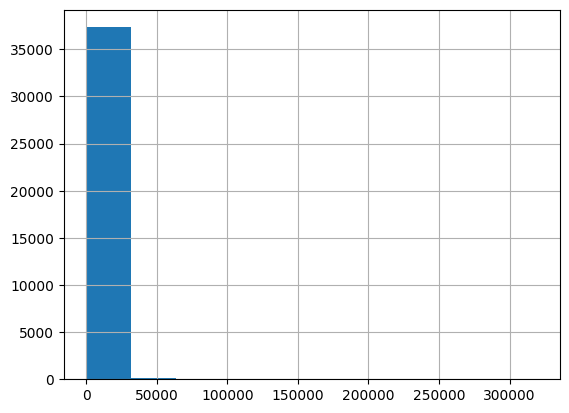

In [6]:
item_count = recomd.groupby('item_id').size().reset_index(name = 'count')
item_count['count'].hist()
plt.show()

In [7]:
# 상위 20% 아이템
threshold = item_count['count'].quantile(0.8)
print(f"임계값 (상위 20%): {threshold}")

임계값 (상위 20%): 274.0


In [8]:
# Old Items와 New Items 분리 - 상위 20% 기준으로
item_count['category'] = item_count['count'].apply(lambda x: 'Old' if x >= threshold else 'New')

old_items = item_count[item_count['category'] == 'Old']
new_items = item_count[item_count['category'] == 'New']

In [9]:
item_count['category'].value_counts()

category
New    30080
Old     7530
Name: count, dtype: int64

In [10]:
new_ids = new_items['item_id']
new_df  = item_group[item_group['item_id'].isin(new_ids)]

old_ids = old_items['item_id']
old_df = item_group[item_group['item_id'].isin(old_ids)]

In [11]:
# Grouped Data 생성
new_item_groups = new_df.groupby('item_id')

# 웜업 단계 크기 K 설정
K = 10

def split_group_safe(data, K):
    """
    데이터를 K 크기로 분리합니다.
    데이터가 부족하면 빈 DataFrame을 반환합니다.
    """
    warm_a = data.iloc[:K] if len(data) >= K else pd.DataFrame()
    warm_b = data.iloc[K:2*K] if len(data) >= 2*K else pd.DataFrame()
    warm_c = data.iloc[2*K:3*K] if len(data) >= 3*K else pd.DataFrame()
    test_set = data.iloc[3*K:] if len(data) > 3*K else pd.DataFrame()
    return warm_a, warm_b, warm_c, test_set

# 웜업 단계 분리 및 유효한 아이템 필터링
warmup_splits = {}

for item_id, item_data in tqdm(new_item_groups, desc="Processing New Items"):
    warm_a, warm_b, warm_c, test_set = split_group_safe(item_data, K)
    
    # 모든 세트에 데이터가 있는 경우에만 추가
    if all(not split.empty for split in [warm_a, warm_b, warm_c, test_set]):
        warmup_splits[item_id] = {
            'warm_a': warm_a,
            'warm_b': warm_b,
            'warm_c': warm_c,
            'test_set': test_set
        }


Processing New Items: 100%|██████████| 30080/30080 [00:16<00:00, 1780.26it/s]


In [12]:
# 단계별 데이터를 저장할 리스트
warm_a_list = []
warm_b_list = []
warm_c_list = []
test_set_list = []

# warmup_splits에서 데이터 추출
for item_id, splits in tqdm(warmup_splits.items(),desc='processing'):
    # 각 단계의 데이터를 추출하고 아이템 ID 추가
    warm_a = splits['warm_a'].copy()
    warm_a['stage'] = 'warm_a'
    warm_a_list.append(warm_a)

    warm_b = splits['warm_b'].copy()
    warm_b['stage'] = 'warm_b'
    warm_b_list.append(warm_b)

    warm_c = splits['warm_c'].copy()
    warm_c['stage'] = 'warm_c'
    warm_c_list.append(warm_c)

    test_set = splits['test_set'].copy()
    test_set['stage'] = 'test_set'
    test_set_list.append(test_set)

# 각각의 데이터프레임으로 병합
warm_a = pd.concat(warm_a_list, ignore_index=True)
warm_b = pd.concat(warm_b_list, ignore_index=True)
warm_c = pd.concat(warm_c_list, ignore_index=True)
test_set = pd.concat(test_set_list, ignore_index=True)


processing: 100%|██████████| 13249/13249 [00:25<00:00, 525.92it/s]


In [13]:
print("Old DataFrame")
print("총 데이터 개수:", len(old_df))
print("고유 item_id 개수:", old_df['item_id'].nunique())
print("고유 user_id 개수:", old_df['user_id'].nunique())
print("-" * 40)

print("Warm A")
print("총 데이터 개수:", len(warm_a))
print("고유 item_id 개수:", warm_a['item_id'].nunique())
print("고유 user_id 개수:", warm_a['user_id'].nunique())
print("-" * 40)

print("Warm B")
print("총 데이터 개수:", len(warm_b))
print("고유 item_id 개수:", warm_b['item_id'].nunique())
print("고유 user_id 개수:", warm_b['user_id'].nunique())
print("-" * 40)

print("Warm C")
print("총 데이터 개수:", len(warm_c))
print("고유 item_id 개수:", warm_c['item_id'].nunique())
print("고유 user_id 개수:", warm_c['user_id'].nunique())
print("-" * 40)

print("Test Set")
print("총 데이터 개수:", len(test_set))
print("고유 item_id 개수:", test_set['item_id'].nunique())
print("고유 user_id 개수:", test_set['user_id'].nunique())
print("-" * 40)


Old DataFrame
총 데이터 개수: 39639864
고유 item_id 개수: 7530
고유 user_id 개수: 13670645
----------------------------------------
Warm A
총 데이터 개수: 132490
고유 item_id 개수: 13249
고유 user_id 개수: 86204
----------------------------------------
Warm B
총 데이터 개수: 132490
고유 item_id 개수: 13249
고유 user_id 개수: 93580
----------------------------------------
Warm C
총 데이터 개수: 132490
고유 item_id 개수: 13249
고유 user_id 개수: 95731
----------------------------------------
Test Set
총 데이터 개수: 894438
고유 item_id 개수: 13249
고유 user_id 개수: 500296
----------------------------------------


---

# 2. 데이터 scaling/encoding

In [145]:
# date와 hours는 negative sampling한다면 사용 불가
recomd

,user_id,item_id,is_recommended,date,unix_date,hours,helpful,funny
0,0,63710,0,2014-06-16,1402876800,2.0000,4,0
1,0,260230,0,2014-06-25,1403654400,5.5000,12,0
2,0,267060,0,2014-09-02,1409616000,11.5000,6,0
3,0,8850,1,2014-09-08,1410134400,61.5000,8,0
4,0,226960,0,2014-09-22,1411344000,1.0000,7,0
...,...,...,...,...,...,...,...,...
14529069,9999939,1147030,1,2021-10-21,1634774400,0.2000,0,0
14529070,9999939,1141030,1,2021-10-21,1634774400,2.0000,0,0
14529071,9999939,1468260,1,2021-11-24,1637712000,18.3000,0,0
14529072,9999939,1481400,1,2022-03-05,1646438400,0.7000,0,0


In [146]:
df_steam = recomd

In [147]:
df_steam['interaction'] = df_steam['is_recommended'].astype(int)

In [148]:
df_steam['interaction'].value_counts()

interaction
1    12144253
0     2384821
Name: count, dtype: int64

In [149]:
# import numpy as np
# import pandas as pd
# from tqdm import tqdm

# def negative_sampling(train_data):
#     """
#     Memory-efficient Negative Sampling using vectorized operations.
    
#     Args:
#         train_data (DataFrame): Data with columns ['user_id', 'item_id', 'interaction']
#         negative_ratio (int): Number of negative samples per positive sample
    
#     Returns:
#         final_train_data (DataFrame): Positive & Negative samples combined
#     """
    
#     # Positive 데이터 추출
#     interacted_data = train_data
#     positive_data_len = train_data['interaction'].sum()
#     negative_data_len = len(train_data) - positive_data_len

#     # 모든 유저와 아이템 목록 추출
#     unique_users = interacted_data['user_id'].unique()
#     all_items = set(train_data['item_id'].unique())  # Set 연산 최적화

#     # Negative 샘플링
#     negative_samples = []
#     user_groups = interacted_data.groupby('user_id')['item_id'].apply(set).to_dict()  # 유저별 상호작용 아이템

#     for user_id in tqdm(unique_users, desc="Generating Negative Samples"):
#         interacted_items = user_groups.get(user_id, set())

#         # 해당 유저가 상호작용하지 않은 아이템 중 랜덤 샘플링
#         non_interacted_items = list(all_items - interacted_items)
#         num_samples = min(0, positive_data_len-negative_data_len)  # Negative 샘플 개수

#         if num_samples > 0:
#             sampled_items = np.random.choice(non_interacted_items, num_samples, replace=False)
#             negative_samples.extend(zip([user_id] * num_samples, sampled_items, [0] * num_samples))

#     # Negative 데이터프레임 생성
#     negative_data = pd.DataFrame(negative_samples, columns=['user_id', 'item_id', 'interaction'])

#     # Positive와 Negative 데이터 합치기
#     final_train_data = pd.concat([interacted_data, negative_data], ignore_index=True)
    
#     print("Positive 데이터 개수:", final_train_data['interaction'].value_counts()[1])
#     print("Negative 데이터 개수:", final_train_data['interaction'].value_counts()[0])

#     # 데이터 섞기 (shuffle)
#     final_train_data = final_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

#     return final_train_data


In [150]:
# recomd['interaction'] = recomd['is_recommended'].astype(int)

In [151]:
# negative_sampled_df = negative_sampling(recomd)

In [152]:
# Load user and item file, join with rating
# df_user = pd.read_csv('users.csv')
df_item = pd.read_csv('item.csv')
# df_steam = df_steam.merge(df_user, on='user_id', how='left')
df_steam = df_steam.merge(df_item, on='item_id', how='left')
df_steam.head(2)

,user_id,item_id,is_recommended,date,unix_date,hours,helpful,funny,interaction,title,date_release,win,mac,linux,positive_ratio,price_final,price_original,steam_deck,estimated_owners,peak_ccu,required_age,price,dlc_count,detailed_description,short_description,supported_languages,metacritic_score,positive,negative,notes,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,developers,publishers,categories,genres,description,tags_sum,rating_encoded,date_release_unix,estimated_owners_mid,review_count
0,0,63710,0,2014-06-16,1402876800,2.0000,4,0,0,BIT.TRIP RUNNER,2011-02-28,1,1,0,87,9.9900,9.9900,1,500000 - 1000000,2.0000,0.0000,9.9900,0.0000,"BIT.TRIP RUNNER is the fastest, most exhilarat...","CommanderVideo is back with BIT.TRIP RUNNER, t...",English,0.0000,3270.0000,530.0000,NaN,170.0000,0.0000,133.0000,0.0000,Gaijin Games,Gaijin Games,"Single-player, Steam Achievements, Full contro...","Action, Indie","CommanderVideo is back with BIT.TRIP RUNNER, t...","2D, Action, Arcade, Casual, Colorful, Controll...",7,1298851200,750000,1278
1,0,260230,0,2014-06-25,1403654400,5.5000,12,0,0,Valiant Hearts: The Great War™ / Soldats Incon...,2014-06-25,1,0,0,95,14.9900,14.9900,1,500000 - 1000000,35.0000,0.0000,14.9900,0.0000,“CHARMING AND DEEPLY MOVING” – IGN “INTRIGUING...,Valiant Hearts : The Great War is the story of...,"English, French, Italian, German, Spanish - Sp...",0.0000,20709.0000,941.0000,NaN,319.0000,0.0000,370.0000,0.0000,Ubisoft Montpellier,Ubisoft,Single-player,Adventure,Valiant Hearts : The Great War is the story of...,"2D, Action, Adventure, Atmospheric, Great Soun...",8,1403654400,750000,5365


In [153]:
df_steam.columns

Index(['user_id', 'item_id', 'is_recommended', 'date', 'unix_date', 'hours',
       'helpful', 'funny', 'interaction', 'title', 'date_release', 'win',
       'mac', 'linux', 'positive_ratio', 'price_final', 'price_original',
       'steam_deck', 'estimated_owners', 'peak_ccu', 'required_age', 'price',
       'dlc_count', 'detailed_description', 'short_description',
       'supported_languages', 'metacritic_score', 'positive', 'negative',
       'notes', 'average_playtime_forever', 'average_playtime_2weeks',
       'median_playtime_forever', 'median_playtime_2weeks', 'developers',
       'publishers', 'categories', 'genres', 'description', 'tags_sum',
       'rating_encoded', 'date_release_unix', 'estimated_owners_mid',
       'review_count'],
      dtype='object')

In [154]:
# Preprocess hours - minmax scaling
min_hours = df_steam['hours'].min()
max_hours = df_steam['hours'].max()
df_steam['hours'] = (df_steam['hours'] - min_hours) / (max_hours - min_hours)

In [155]:
# # Preprocess titles - multi label encoding
# tokenizer = RegexpTokenizer(r'\w+')
# titles = df_steam['title']
# tokenized_titles = []
# titles = [tokenizer.tokenize(str(title)) for title in list(titles)]
# vocab = []
# max_title_len = 0
# for title in titles:
#     vocab += title
#     max_title_len = max_title_len if max_title_len > len(title) else len(title)
# vocab = set(vocab)
# word2idx = {word: idx for idx, word in enumerate(vocab)}
# res_title = []
# for title in titles:
#     padding_title = [word2idx[word] for word in title]
#     padding_title.extend([0 for i in range(max_title_len - len(title))])
#     res_title.append(padding_title)
# df_steam['title'] = res_title
# df_steam['title']

In [156]:
# Preprocess date_release - minmax scaling
df_steam['date_release'] = pd.to_datetime(df_steam['date_release'])
df_steam['date_release'] = (df_steam['date_release'] - pd.Timestamp("1970-01-01")).dt.days
min_date = np.min(df_steam['date_release'])
max_date = np.max(df_steam['date_release'])

df_steam['date_release'] = df_steam['date_release'].map(lambda x: (x - min_date) / (max_date - min_date))

In [157]:
# Preprocess positive_ratio - minmax scaling
df_steam['positive_ratio'] = df_steam['positive_ratio'].map(lambda x: x / 100)

In [158]:
# Preprocess price_final & price_original - minmax scaling
min_price_final = df_steam['price_final'].min()
max_price_final = df_steam['price_final'].max()
df_steam['price_final'] = (df_steam['price_final'] - min_price_final) / (max_price_final - min_price_final)

min_price_original = df_steam['price_original'].min()
max_price_original = df_steam['price_original'].max()
df_steam['price_original'] = (df_steam['price_original'] - min_price_original) / (max_price_original - min_price_original)

In [159]:
# Preprocess peak_ccu - minmax scaling
min_peak_ccu = df_steam['peak_ccu'].min()
max_peak_ccu = df_steam['peak_ccu'].max()
df_steam['peak_ccu'] = (df_steam['peak_ccu'] - min_peak_ccu) / (max_peak_ccu - min_peak_ccu)

In [160]:
# Preprocess required_age - binary encoding: over 16 or not
df_steam["required_age"].value_counts().sort_index()
df_steam['required_age'] = df_steam['required_age'].map(lambda x: 1 if x >= 16 else 0)

In [161]:
# Preprocess price - minmax scaling
min_price = df_steam['price'].min()
max_price = df_steam['price'].max()
df_steam['price'] = (df_steam['price'] - min_price) / (max_price - min_price)

In [162]:
# # Preprocess supported_languages - multi label encoding
# df_steam.fillna({"supported_languages": ""}, inplace=True)
# supported_languages = df_steam['supported_languages']
# lang2idx = {}
# cnt = 0
# res_lang = []
# max_lang_len = 0
# for lang_str in supported_languages:
#     lang_list = [lang.strip() for part in lang_str.split(",") for lang in part.split("-")]
#     max_lang_len = max(max_lang_len, len(lang_list))
#     for lang in lang_list:
#         if lang not in lang2idx:
#             lang2idx[lang] = cnt
#             cnt += 1
#     res_lang.append([lang2idx[lang] for lang in lang_list])
# for lang in res_lang:
#     lang.extend([0 for i in range(max_lang_len - len(lang))])
# df_steam['supported_languages'] = res_lang
# df_steam['supported_languages']

In [163]:
# Preprocess metacritic_score - minmax scaling
df_steam['metacritic_score'] = df_steam['metacritic_score'].map(lambda x: x / 100)

In [164]:
# Preprocess date - minmax scaling
df_steam['date'] = pd.to_datetime(df_steam['date'])
df_steam['date'] = (df_steam['date'] - pd.Timestamp("1970-01-01")).dt.days
min_date = np.min(df_steam['date'])
max_date = np.max(df_steam['date'])

df_steam['date'] = df_steam['date'].map(lambda x: (x - min_date) / (max_date - min_date))
df_steam = df_steam.sort_values(by='date')  # 시간순 정렬

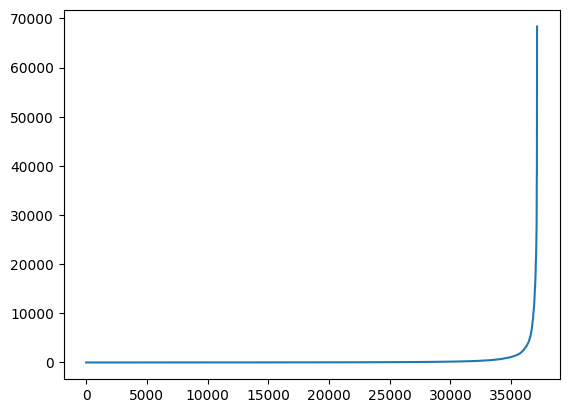

In [165]:
# plot item counts vs item
user2count = df_steam.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
item_ids = list(user2count['item_id'])
counts = np.array(user2count['count'])
plt.plot(np.arange(len(counts)), counts)

In [166]:
# Preprocess count
df_steam = df_steam.join(user2count.set_index('item_id'), on='item_id')
min_count = np.min(df_steam['count'])
max_count = np.max(df_steam['count'])
df_steam['count'] = df_steam['count'].map(lambda x: (x - min_count) / (max_count - min_count))

In [167]:
# # Join with text embedding
# with open('./item_embeddings.pkl', 'rb') as f:
#     data = pickle.load(f)
# data['tag_embedding'] = data['tag_embedding'].apply(lambda x: x.tolist())
# data["category_embedding"] = data["category_embedding"].apply(lambda x: x.tolist())
# data["combined_embedding"] = data["combined_embedding"].apply(lambda x: x.tolist())

# df_steam = df_steam.merge(data, on='item_id', how='left')

In [168]:
df_steam.head(2)

,user_id,item_id,is_recommended,date,unix_date,hours,helpful,funny,interaction,title,date_release,win,mac,linux,positive_ratio,price_final,price_original,steam_deck,estimated_owners,peak_ccu,required_age,price,dlc_count,detailed_description,short_description,supported_languages,metacritic_score,positive,negative,notes,average_playtime_forever,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,developers,publishers,categories,genres,description,tags_sum,rating_encoded,date_release_unix,estimated_owners_mid,review_count,count,combined_embedding,tag_embedding,category_embedding
0,8474772,22380,1,0.0000,1287100800,0.4288,2,0,1,Fallout: New Vegas,0.5087,1,0,0,0.9600,0.0370,0.0000,1,2000000 - 5000000,0.0070,1,0.0370,7.0000,Welcome to Vegas. New Vegas. It’s the kind of ...,Welcome to Vegas. New Vegas. Enjoy your stay!,"English, French, German, Italian, Spanish - Spain",0.8400,154845.0000,5667.0000,NaN,3044.0000,112.0000,976.0000,153.0000,Obsidian Entertainment,Bethesda Softworks,"Single-player, Steam Achievements, Partial Con...","Action, RPG",NaN,"Action, Adventure, Atmospheric, Exploration, F...",8,1287446400,3500000,35446,0.5185,"[0.04676687344908714, -0.10566429793834686, 0....","[-0.5121199488639832, -0.12097563594579697, -0...","[0.4960460066795349, 0.07515629380941391, 0.05..."
1,11064475,440,1,0.0000,1287100800,0.6228,2,0,1,Team Fortress 2,0.3930,1,1,1,0.9300,0.0000,0.0000,1,50000000 - 100000000,0.1305,0,0.0000,1.0000,"""The most fun you can have online"" - PC Gamer ...",Nine distinct classes provide a broad range of...,"English, Danish, Dutch, Finnish, French, Germa...",0.9200,823693.0000,56683.0000,Includes cartoon violence and gore.,9916.0000,2299.0000,370.0000,694.0000,Valve,Valve,"Multi-player, Cross-Platform Multiplayer, Stea...","Action, Free to Play",NaN,"Action, Co-op, Comedy, FPS, First-Person, Free...",7,1191974400,75000000,68366,1.0000,"[0.12863539159297943, -0.07096611708402634, -0...","[-0.10960102081298828, 0.08488725125789642, 0....","[0.3045477271080017, 0.25805172324180603, 0.11..."


In [ ]:
# define unique function
def _unique(sample, fname):
    tmp_df = pd.DataFrame()
    tmp_df[fname] = sample[fname].unique()
    num = len(tmp_df)
    tmp_df['tmp_feature'] = range(num)
    sample = sample.join(tmp_df.set_index(fname), on=fname)
    sample.drop(fname, axis=1, inplace=True)
    sample = sample.rename(columns = {"tmp_feature": fname})
    return num, sample

num_user, df_steam = _unique(df_steam, 'user_id')
num_app, df_steam = _unique(df_steam, 'item_id')

# Reorder columns
# orders = ['user_id', 'item_id', 'hours', 'date_release', 'positive_ratio', 'price_final', 'price_original', 'peak_ccu', 'required_age', 'price', 'metacritic_score', 'date', 'count', 'combined_embedding', 'tag_embedding', 'category_embedding', 'interaction']
orders = ['user_id', 'item_id', 'hours', 'date_release', 'positive_ratio', 'price_final', 'price_original', 'peak_ccu', 'required_age', 'price', 'metacritic_score', 'date', 'count', 'interaction']
df_steam = df_steam[orders]
description = [
    ('user_id', num_user, 'spr'),  # 변환된 유저 ID
    ('item_id', num_app, 'spr'),  # 변환된 게임(아이템) ID
    ('hours', -1, 'ctn'),  # 플레이 시간
    ('date_release', -1, 'ctn'),  # 출시일
    ('positive_ratio', -1, 'ctn'),  # 긍정적인 평가 비율
    ('price_final', -1, 'ctn'),  # 최종 가격
    ('price_original', -1, 'ctn'),  # 원래 가격
    ('peak_ccu', -1, 'ctn'),  # 최대 동시 접속자 수
    ('required_age', 1 + np.max(df_steam["required_age"]), 'spr'),  # 필요한 나이
    ('price', -1, 'ctn'),  # 가격
    ('metacritic_score', -1, 'ctn'),  # 메타크리틱 점수
    ('date', -1, 'ctn'),  # 정규화된 날짜
    ('count', -1, 'ctn'),  # 리뷰 수
    # ('combined_embedding', len(df_steam["combined_embedding"].iloc[0]), 'emb'),  # title + description 결합 임베딩
    # ('tag_embedding', len(df_steam["tag_embedding"].iloc[0]), 'emb'),  # 태그 임베딩
    # ('category_embedding', len(df_steam["category_embedding"].iloc[0]), 'emb'),  # 카테고리 임베딩
    ('interaction', 2, 'label'),  # 클릭 여부
]
description


[('user_id', 680812, 'spr'),
 ('item_id', 37141, 'spr'),
 ('hours', -1, 'ctn'),
 ('date_release', -1, 'ctn'),
 ('positive_ratio', -1, 'ctn'),
 ('price_final', -1, 'ctn'),
 ('price_original', -1, 'ctn'),
 ('peak_ccu', -1, 'ctn'),
 ('required_age', 2, 'spr'),
 ('price', -1, 'ctn'),
 ('metacritic_score', -1, 'ctn'),
 ('date', -1, 'ctn'),
 ('count', -1, 'ctn'),
 ('combined_embedding', 256, 'emb'),
 ('tag_embedding', 64, 'emb'),
 ('category_embedding', 32, 'emb'),
 ('interaction', 2, 'label')]

In [170]:
assert df_steam.isna().sum().sum() == 0, 'There are missing values in the preprocessed data!!'

# 3. 데이터 Split

In [172]:
def split_2(df_ratings, description, N=274, K=10):
    user2count = df_ratings.groupby(['item_id']).size().reset_index(name='count').sort_values(by='count')
    item_ids = user2count['item_id'].to_numpy()
    counts = user2count['count'].to_numpy()

    hot_item_ids = item_ids[counts > N]
    cold_item_ids = item_ids[(counts <= N) & (counts >= 3 * K)]

    item_group = df_ratings.groupby('item_id')

    train_base_list = []
    for item_id in hot_item_ids:
        df_hot = item_group.get_group(item_id).sort_values(by='date')
        train_base_list.append(df_hot)

    train_base = pd.concat(train_base_list, ignore_index=True)

    train_warm_a_list, train_warm_b_list, train_warm_c_list, test_list = [], [], [], []
    
    for item_id in cold_item_ids:
        df_cold = item_group.get_group(item_id).sort_values(by='date')
        train_warm_a_list.append(df_cold[:K])
        train_warm_b_list.append(df_cold[K:2*K])
        train_warm_c_list.append(df_cold[2*K:3*K])
        test_list.append(df_cold[3*K:])
    
    train_warm_a = pd.concat(train_warm_a_list, ignore_index=True)
    train_warm_b = pd.concat(train_warm_b_list, ignore_index=True)
    train_warm_c = pd.concat(train_warm_c_list, ignore_index=True)
    test = pd.concat(test_list, ignore_index=True)

    save_dic = {
        'train_base': train_base.sort_values('date'),
        'train_warm_a': train_warm_a.sort_values('date'),
        'train_warm_b': train_warm_b.sort_values('date'),
        'train_warm_c': train_warm_c.sort_values('date'),
        'test': test.sort_values('date'),
        'description': description
    }

    for name, df in save_dic.items():
        # with open('./emb_warm_split_{}.pkl'.format(name), 'bw+') as f:
        #     pickle.dump(df, f, protocol = pickle.HIGHEST_PROTOCOL)
        print("{} size: {}".format(name, len(df)))

    with open('./emb_warm_split_preprocess.pkl', 'bw+') as f:
        pickle.dump(save_dic, f, protocol = pickle.HIGHEST_PROTOCOL)


In [33]:
df_steam.memory_usage(deep=True).sum() / (1024**2)

122346.48896789551

In [173]:
df_steam.memory_usage(deep=True).sum() / (1024**2)

43230.73483276367

In [39]:
df_steam.memory_usage(deep=True).sum() / (1024**2)

1662.7205657958984

In [40]:
buffer = io.BytesIO()
pickle.dump(df_steam, buffer, protocol=4)
estimated_size = buffer.getbuffer().nbytes / (1024**2)  # MB 단위
print(f"Estimated Pickle File Size: {estimated_size:.2f} MB")


Estimated Pickle File Size: 1662.72 MB


In [ ]:
split_2(df_steam, description)

train_base size: 13146868
train_warm_a size: 122240
train_warm_b size: 122240
train_warm_c size: 122240
test size: 793248
description size: 17


: 

In [2]:
# Get training data for Meta-Embedding method
with open('./emb_warm_split_preprocess.pkl', 'rb') as f:
    data = pickle.load(f)

df_base = data['train_base']
item2group = df_base.groupby('item_id')

train_a_list, train_b_list, train_c_list, train_d_list = [], [], [], []

for item_id, df_group in tqdm(item2group):
    l, e = df_group.shape[0], df_group.shape[0] // 4     
    train_a_list.append(df_group.iloc[0:e])
    train_b_list.append(df_group.iloc[e: 2 * e])
    train_c_list.append(df_group.iloc[2 * e: 3 * e])
    train_d_list.append(df_group.iloc[3 * e: 4 * e]) 

train_a = pd.concat(train_a_list, ignore_index=True)
train_b = pd.concat(train_b_list, ignore_index=True)
train_c = pd.concat(train_c_list, ignore_index=True)
train_d = pd.concat(train_d_list, ignore_index=True)

shuffle_idx = np.random.permutation(train_a.shape[0])
train_a = train_a.iloc[shuffle_idx]
train_b = train_b.iloc[shuffle_idx]
train_c = train_c.iloc[shuffle_idx]
train_d = train_d.iloc[shuffle_idx]

data["metaE_a"] = train_a
data["metaE_b"] = train_b
data["metaE_c"] = train_c
data["metaE_d"] = train_d

with open('./steam_data.pkl', 'wb') as f:
    pickle.dump(data, f)


100%|██████████| 5421/5421 [00:09<00:00, 550.95it/s] 


In [43]:
print("데이터 타입:", type(data))
print("데이터 크기:", len(data) if isinstance(data, dict) else "Not a dict")
print("데이터 키 목록:", data.keys() if isinstance(data, dict) else "Not a dict")


데이터 타입: <class 'dict'>
데이터 크기: 10
데이터 키 목록: dict_keys(['train_base', 'train_warm_a', 'train_warm_b', 'train_warm_c', 'test', 'description', 'metaE_a', 'metaE_b', 'metaE_c', 'metaE_d'])
